# IMDB 5000 Movie Dataset Clustering

===========================================================================================================

**AUTHOR**: Mengshan Jin

**CREATION DATE**: 08/04/2017

===========================================================================================================

**PROGRAM DESCRIPTION**: Clustering on the movies using the text data only

**INPUT DATASETS**: 01_Data/Outputs/imdb_modern_cleaned.csv

**OUTPUT DATASETS**: 

**SCOPE**: 1980-2016 English movies

===========================================================================================================

**PROGRAM CHANGE HISTORY**

Date|Author|Change|
----|------|------|

# Section 0: Import packages

In [99]:
# Data structure
import numpy as np
import pandas as pd
np.random.seed(7)
# pd.options.mode.chained_assignment = None  # default='warn'

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# utilities
import copy
import re
import string

# nltk
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.tag import StanfordNERTagger
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.externals import joblib

# Section 1: Read data

In [7]:
imdb_with_storyline = pd.read_csv("../../01_Data/Outputs/imdb_with_storyline.csv")

In [9]:
imdb_with_storyline.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,storyline
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,"When his brother is killed in a robbery, parap..."
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,"After Elizabeth, Will, and Captain Barbossa re..."
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,A cryptic message from the past sends James Bo...
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,Despite his tarnished reputation after the eve...
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0,NaN


In [22]:
imdb_with_storyline = imdb_with_storyline.drop_duplicates()

In [23]:
imdb_with_storyline.shape

(4998, 29)

# Section 2: Clustering with Text

## Step 1: Split the dataset into training and out-of-time sample testing datasets

In [24]:
imdb_train = imdb_with_storyline.loc[(imdb_with_storyline['title_year'] < 2015) & (imdb_with_storyline['title_year'] >= 1980) & 
                                     (imdb_with_storyline['language'] == "English")]
imdb_test = imdb_with_storyline.loc[(imdb_with_storyline['title_year'] >= 2015) & (imdb_with_storyline['language'] == "English")]

In [25]:
imdb_train.shape

(4024, 29)

In [26]:
imdb_test.shape

(301, 29)

### ==>Task to do<==
Inconsistent number of observations for codified data and text data.    
When combining, need to re-pull storyline based on imdb_modern_cleaned

## Step 2: Subset the storyline

In [51]:
storyline_train = pd.DataFrame(imdb_train[['storyline', 'imdb_score', 'num_critic_for_reviews']]).set_index(imdb_train['movie_title'])

In [52]:
storyline_train.head()

,storyline,imdb_score,num_critic_for_reviews
movie_title,,,
Avatar,"When his brother is killed in a robbery, parap...",7.9,723.0
Pirates of the Caribbean: At World's End,"After Elizabeth, Will, and Captain Barbossa re...",7.1,302.0
The Dark Knight Rises,Despite his tarnished reputation after the eve...,8.5,813.0
John Carter,"John Carter, a Civil War veteran, who in 1868 ...",6.6,462.0
Spider-Man 3,Peter Parker has finally managed to piece toge...,6.2,392.0


In [53]:
storyline_train.loc[storyline_train['storyline'].isnull()]

,storyline,imdb_score,num_critic_for_reviews
movie_title,,,
Michael Jordan to the Max,NaN,7.5,14.0


In [64]:
storyline_train['storyline'].fillna("NA", inplace=True)

In [65]:
storyline_train.loc['Michael Jordan to the Max\xc2\xa0']

storyline                  NA
imdb_score                7.5
num_critic_for_reviews     14
Name: Michael Jordan to the Max , dtype: object

## Step 3: Build pipeline to train models

In [31]:
stop_list = stopwords.words('english') + ["'s", "n't", "``", "", "...", "--"]

In [34]:
def text2int(textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):    numwords[word] = (1, idx)
        for idx, word in enumerate(tens):     numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales):   numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
            raise Exception("Illegal word: " + word)
        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

In [35]:
def summarize_x_year_old(x_year_old):
    tmp = re.sub('-', ' ', re.split(r'-year-old', x_year_old)[0])
    try:
        x = int(tmp)
    except ValueError:
        try:
            x = text2int(tmp)
        except Exception:
            return x_year_old
    if x < 12:
        return "childhood"
    elif x < 21:
        return "adolescence"
    elif x < 36:
        return "early-adulthood"
    elif x < 51:
        return "midlife"
    else:
        return "late-adulthood"

In [36]:
synonyms = {
    'dr.':'doctor',
    'u.s.':'united-states',
    "'ll":"will",
    "'ve":"have",
    "'d":"would",
    'l.a.':'los-angeles',
    'year-old':'year old',
    'jr.':'junior',
    'small-town':'small town',
    'real-life':'real life',
    'co-worker':'colleague',
    'a.k.a':'also known as',
    'st.':'street',
    'would-be':'would be',
    'long-time':'long time',
    'self-defense':'self defense',
    'co-workers':'colleague',
    'modern-day':'modern',
    'd.c.':'washington-dc',
    'top-secret':'top secret',
    'next-door':'neighbor',
    'face-to-face':'face to face',
    'mild-mannered':'mild manner',
    'part-time':'part time',
    'self-discovery':'self discovery',
    'one-time':'one time',
    'high-speed':'high speed',
    'high-tech':'high technology',
    'so-called':'so called',
    'new-found':'newly found',
    'long-term':'long term',
    'u.s':'united states',
    'sci-fi':'science fiction',
    'up-and-coming':'upcoming',
    'soon-to-be':'soon to be',
    'all-out':'all out',
    'one-night':'one night',
    'best-selling':'best selling',
    '3-d':'3 dimensions',
    'husband-and-wife':'husband and wife',
    'wedding-plans':'wedding plans',
    'salesman/font':'salesman',
    'mid-twenty-year-old':'young adulthood',
    'ten-and-a-half-year-old':'childhood'
}

In [56]:
def custom_tokenizer(storyline):
    token_list = [item.lower().strip("'") for item in word_tokenize(storyline) if item not in string.punctuation]
    tokens = [item for item in token_list if item not in stop_list]
    tokens_clean_years = [summarize_x_year_old(x) if x.find("-year-old") != -1 else x for x in tokens]
    tokens_sub_synonyms = [x if x not in synonyms.keys() else synonyms[x] for x in tokens_clean_years]
    tokens_remove_dot = [x for x in tokens_sub_synonyms if re.match(r"[a-z]\.$", x) == None]
    tokens_split = [x for item in tokens_remove_dot for x in item.split(" ")]
    tokens = [item for item in tokens_split if item not in stop_list]
    return tokens

In [48]:
def standardized_measure(df, col):
    return (df[col] - df[col].min())/(df[col].max() - df[col].min())

In [49]:
def harmonic_mean(row):
    try:
        return 1/(0.7*row[0]+0.3*row[1])
    except ZeroDivisionError:
        return np.nan

In [50]:
def goodness_deviance(list_num):
    num_avg = np.mean(list_num)
    return np.sqrt(np.sum([(item-num_avg)**2 for item in list_num])/len(list_num))

In [54]:
# write my own loop function to select the best combination of parameters
def clustering_grid_search_text(df, text_col, pipe, param_grid):
    best_i = -1
    best_dev = 0
    res_dict = {}
    for i in range(len(param_grid)):
        cluster_model = pipe.set_params(**param_grid[i])
        cluster_pred = cluster_model.fit_predict(df[text_col])
        tmp = pd.concat([df[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                         pd.Series(cluster_pred, name="cluster_num")], axis=1)
        tmp['imdb_score'] = standardized_measure(tmp, 'imdb_score')
        tmp['num_critic_for_reviews'] = standardized_measure(tmp, 'num_critic_for_reviews')
        tmp['harmonic_mean'] = tmp[['imdb_score', 'num_critic_for_reviews']].apply(harmonic_mean, axis = 1)
        tmp_gp = tmp.groupby('cluster_num').aggregate({'harmonic_mean':np.mean})
        curr_dev = goodness_deviance(tmp_gp['harmonic_mean'])
        res_dict[i] = [param_grid[i], {"Deviance":curr_dev}]
        if curr_dev > best_dev:
            best_dev = curr_dev
            best_i = i
    print "Best parameters combination:", param_grid[best_i], "\nDeviance:", best_dev
    return res_dict

## Models to choose from:
1. Agglomerative Clustering (3 linkages)
2. KMeans
3. DBSCAN

### Agglomerative Clustering with Ward linkage criterion
Use SVD to reduce dimensions

In [58]:
pipe_count_svd_ward = Pipeline([('vectorizer', CountVectorizer(stop_words=stop_list,
                                                          tokenizer=custom_tokenizer,
                                                          ngram_range=(1,4))),
                               ('svd', TruncatedSVD()),
                               ('normalizer', Normalizer(copy=False)),
                               ('clustering', AgglomerativeClustering())
                              ])

param_grid_svd_ward = {'vectorizer__max_df':[0.5,0.6,0.7,0.8],
                       'vectorizer__min_df':list(np.arange(5,9)),
                       'svd__n_components':[50,75,100,125],
                       'clustering__n_clusters':[10, 30, 50]}
param_grid_svd_ward = list(ParameterGrid(param_grid_svd_ward))

In [66]:
res_count_svd_ward = clustering_grid_search_text(storyline_train, "storyline", pipe_count_svd_ward, param_grid_svd_ward)

Best parameters combination: {'vectorizer__min_df': 8, 'vectorizer__max_df': 0.8, 'clustering__n_clusters': 50, 'svd__n_components': 125} 
Deviance: 0.376550531093


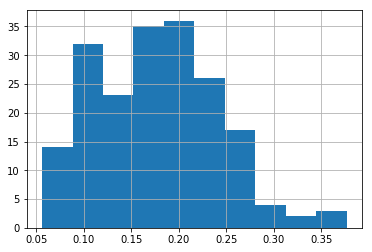

In [67]:
# check deviance distribution
lrs_count_svd_ward = [value[1]['Deviance'] for value in res_count_svd_ward.values()]
pd.Series(lrs_count_svd_ward).hist()

In [69]:
joblib.dump(res_count_svd_ward, 'pickles/count_svd_ward_params.pkl', compress=1) # pickle the parameters and the results

['pickles/count_svd_ward_params.pkl']

#### Investigation
1. Size of each cluster
2. Differentiation between good movies and bad movies
3. Quality of Inception group

In [79]:
def get_best_model_id(res_dict):
    return sorted({key:value[1]['Deviance'] for key, value in res_dict.items()}.items(), key=lambda t: t[1], reverse=True)[0][0]

In [80]:
count_svd_ward_best_model = pipe_count_svd_ward.set_params(**param_grid_svd_ward[get_best_model_id(res_count_svd_ward)])

In [82]:
tmp = pd.concat([storyline_train[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                 pd.Series(count_svd_ward_best_model.fit_predict(storyline_train['storyline']), 
                           name="count_svd_ward_cluster_num")], axis=1)

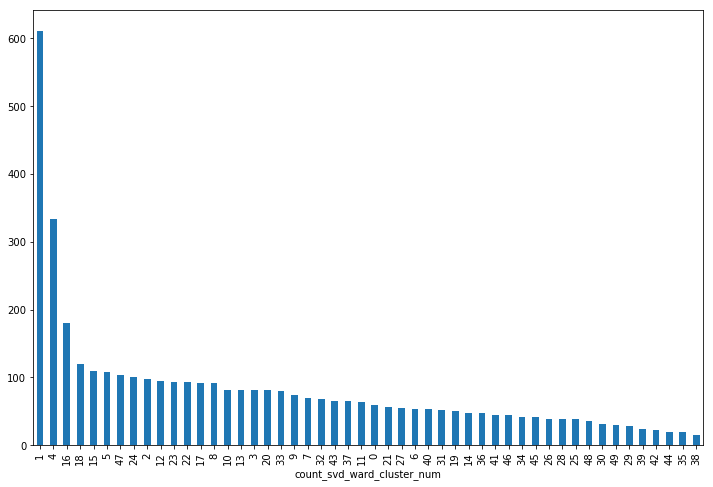

In [93]:
plt.figure(figsize=(12, 8))
tmp.groupby('count_svd_ward_cluster_num').size().sort_values(ascending=False).plot(kind="bar")

In [97]:
count_svd_ward_top_clusters = tmp.loc[tmp['count_svd_ward_cluster_num'].isin(tmp.groupby('count_svd_ward_cluster_num').size().sort_values(ascending=False)[:8].index.tolist())]

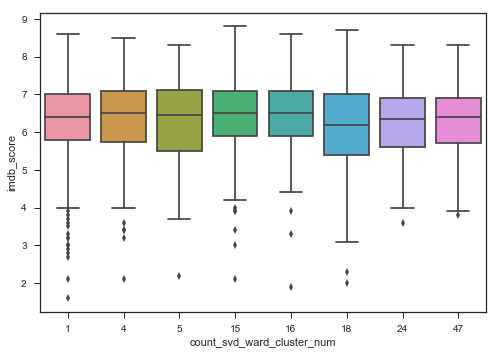

In [101]:
sns.boxplot(x='count_svd_ward_cluster_num', y='imdb_score', data=count_svd_ward_top_clusters)

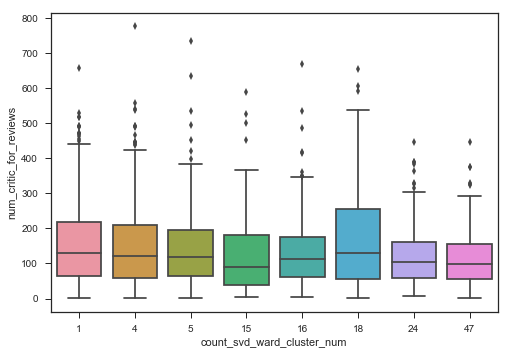

In [102]:
sns.boxplot(x='count_svd_ward_cluster_num', y='num_critic_for_reviews', data=count_svd_ward_top_clusters)

It looks like there is no imdb_score difference in these top 8 clusters, but I guess that doesn't necessarily mean that this result is bad.

In [103]:
tmp = copy.deepcopy(storyline_train)
tmp['count_svd_ward_cluster_num'] = count_svd_ward_best_model.fit_predict(tmp['storyline'])

In [105]:
tmp.loc[tmp['count_svd_ward_cluster_num'] == 1]

,storyline,imdb_score,num_critic_for_reviews,count_svd_ward_cluster_num
movie_title,,,,
The Hobbit: The Battle of the Five Armies,"After the Dragon leaves the Lonely Mountain, t...",7.5,422.0,1
Transformers: Age of Extinction,After the battle between the Autobots and Dece...,5.7,378.0,1
X-Men: First Class,Before Charles Xavier and Erik Lensherr took t...,7.8,500.0,1
How the Grinch Stole Christmas,Inside a snowflake exists the magical land of ...,6.0,175.0,1
Elysium,"In the year 2154, two classes of people exist:...",6.6,476.0,1
Windtalkers,During World War II when the Americans needed ...,6.0,152.0,1
The Taking of Pelham 1 2 3,"In early afternoon, four armed men hijack a su...",6.4,267.0,1
Catwoman,"Catwoman is the story of shy, sensitive artist...",3.3,212.0,1
The Girl with the Dragon Tattoo,This English-language adaptation of the Swedis...,7.8,517.0,1


In [107]:
tmp.loc[tmp['count_svd_ward_cluster_num'] == tmp.loc['Inception\xc2\xa0']['count_svd_ward_cluster_num']]

,storyline,imdb_score,num_critic_for_reviews,count_svd_ward_cluster_num
movie_title,,,,
Toy Story 3,"Woody, Buzz and the whole gang are back. As th...",8.3,453.0,17
Inception,"Dom Cobb is a skilled thief, the absolute best...",8.8,642.0,17
Watchmen,In a gritty and alternate 1985 the glory days ...,7.7,451.0,17
Sahara,Master explorer and former US Navy Seal Dirk P...,6.0,163.0,17
Fast Five,Former cop Brian O'Conner partners with ex-con...,7.3,342.0,17
Enemy at the Gates,"In World War II, the fall of Stalingrad will m...",7.6,187.0,17
Red Dragon,3 Years after retiring from the FBI because of...,7.2,210.0,17
I Spy,"When the Switchblade, the most sophisticated p...",5.4,105.0,17
Wyatt Earp,Wyatt Earp is a movie about a man and his fami...,6.6,40.0,17
